# **[Chapter 13]**  
**┗ 기후 데이터 이상 탐지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「시계열 분해」
* 🥇Session 3 - 「이상 탐지 모델링」

In [2]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Anomaly Detection (FC)/Step 3. 도메인별 이상탐지 실습/[03] Chapter 13. 기후 데이터 이상 탐지")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/Anomaly Detection (FC)/Step 3. 도메인별 이상탐지 실습/[03] Chapter 13. 기후 데이터 이상 탐지'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🌨

```
A사는 기후 변화에 따라 방안의 온도를 유지시켜주는 공조 시스템 솔루션을 개발 중에 있다. 해당 솔루션의 핵심 기술은 외부  
기온 변화에 따라 적절한 온도를 유지시켜주는 자동 유지 시스템이라고 할 수 있다. 해당 기술을 구현하기 위해 A사는 외부 기후 이상 탐지 모델을  
개발하고, 외부 온도가 특정 threshold를 벗어나면 공조 시스템을 가동하는 시스템을 운영하고자 한다.

```  

> **데이터 살펴보기**

* 외부 기후 데이터 
* 데이터 명세 ⬇ 

|Column|Description|
|:---|:---|
|date|날짜|
|meantemp|평균온도|
|humidity|습도|
|wind_speed|풍속|
|meanpressure|평균기압|

In [3]:
# ▶ pd.set option
import pandas as pd 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  

# ▶ Data read
df_train = pd.read_csv("chapter13_df_train.csv")
df_test = pd.read_csv("chapter13_df_test.csv")

df = pd.concat([df_train, df_test], axis=0)
df = df.reset_index(drop=True)
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1571,2017-04-20,34.500000,27.500000,5.562500,998.625000
1572,2017-04-21,34.250000,39.375000,6.962500,999.875000
1573,2017-04-22,32.900000,40.900000,8.890000,1001.600000
1574,2017-04-23,32.875000,27.500000,9.962500,1002.125000



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 내부 온도 유지 시스템 핵심 로직 개발 필요
```  

> **기대효과**

```
▶ 핵심 로직 개발 및 공조 시스템 솔루션 개발 진행
```

> **해결방안**

```
▶ 외부 온도 변화 이상 감지 및 내부 온도 변환 로직 개발 
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 시계열 분해를 통해 데이터 이해 
▶ Session 3 🥇
 - 이상 탐지 모델링 수행 
```

> **성과측정**  

```
▶ 이상탐지 로직 정확도 측정
```

> **현업적용**  

```
▶ 개발 로직 활용 실험 테스트 진행 및 테스트 결과 확인
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → .duplicated(), drop_duplicates()
▶ Session 2 → .set_index(), resample('D').mean(), STL()
▶ Session 3 → ztest(r), .fill_between(), np.int64(df_shesd['date'])
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  

In [4]:
# ▶ Data 형태 확인
# ▶ 1576 row, 5 col로 구성됨
print('df :', df.shape)

df : (1576, 5)


In [5]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1576 non-null   object 
 1   meantemp      1576 non-null   float64
 2   humidity      1576 non-null   float64
 3   wind_speed    1576 non-null   float64
 4   meanpressure  1576 non-null   float64
dtypes: float64(4), object(1)
memory usage: 61.7+ KB


In [6]:
# ▶ 시간 Type 변경
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1576 non-null   datetime64[ns]
 1   meantemp      1576 non-null   float64       
 2   humidity      1576 non-null   float64       
 3   wind_speed    1576 non-null   float64       
 4   meanpressure  1576 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 61.7 KB


In [7]:
# ▶ 중복 확인
pd.Series(df['date'].duplicated()).value_counts()

False    1575
True        1
Name: date, dtype: int64

In [8]:
# ▶ 중복값 
df[df['date'].duplicated()]

,date,meantemp,humidity,wind_speed,meanpressure
1462,2017-01-01,15.913043,85.869565,2.743478,59.0


In [9]:
# ▶ 중복값 
df[df['date'] == '2017-01-01']

,date,meantemp,humidity,wind_speed,meanpressure
1461,2017-01-01,10.000000,100.000000,0.000000,1016.0
1462,2017-01-01,15.913043,85.869565,2.743478,59.0


In [10]:
# ▶ 중복값, meanpressure 59.0은 이상한 값
df[df['date'] >= '2017-01-01'].head(10)

,date,meantemp,humidity,wind_speed,meanpressure
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000
1462,2017-01-01,15.913043,85.869565,2.743478,59.000000
1463,2017-01-02,18.500000,77.222222,2.894444,1018.277778
1464,2017-01-03,17.111111,81.888889,4.016667,1018.333333
1465,2017-01-04,18.700000,70.050000,4.545000,1015.700000
1466,2017-01-05,18.388889,74.944444,3.300000,1014.333333
1467,2017-01-06,19.318182,79.318182,8.681818,1011.772727
1468,2017-01-07,14.708333,95.833333,10.041667,1011.375000
1469,2017-01-08,15.684211,83.526316,1.950000,1015.550000
1470,2017-01-09,14.571429,80.809524,6.542857,1015.952381


In [11]:
# ▶ 중복값 다시 확인
df = df.drop_duplicates(['date'], keep='first').reset_index(drop=True)
pd.Series(df['date'].duplicated()).value_counts()

False    1575
Name: date, dtype: int64

In [12]:
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1570,2017-04-20,34.500000,27.500000,5.562500,998.625000
1571,2017-04-21,34.250000,39.375000,6.962500,999.875000
1572,2017-04-22,32.900000,40.900000,8.890000,1001.600000
1573,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [13]:
# ▶ Null 값 확인
print(df.isnull().sum())

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [14]:
# ▶ Outlier 확인
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1575.000000,1575.000000,1575.00000,1575.000000
mean,25.227828,60.429087,6.90190,1011.197364
std,7.343597,16.973286,4.51094,173.648628
min,6.000000,13.428571,0.00000,-3.041667
25%,18.516667,49.750000,3.70000,1001.875000
50%,27.166667,62.380952,6.37000,1009.111111
75%,31.142857,72.125000,9.26250,1015.200000
max,38.714286,100.000000,42.22000,7679.333333


★ 실제로 처음 접하는 변수가 많음. 이상치인지 여부를 판단하려면 결국 도메인 지식이 필요   
> 현업과 데이터 탐색 결과를 함께 보면서 이상치 여부를 논의하는 것이 필수

<AxesSubplot:xlabel='meanpressure', ylabel='Density'>

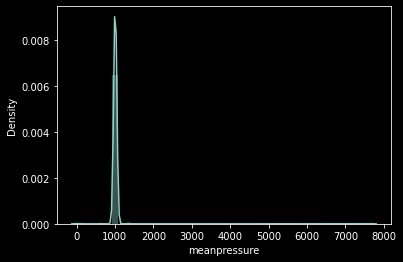

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.distplot(df['meanpressure'])

### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [16]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [17]:
# ▶ date ragne 확인
df['date'].min(), df['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-04-24 00:00:00'))

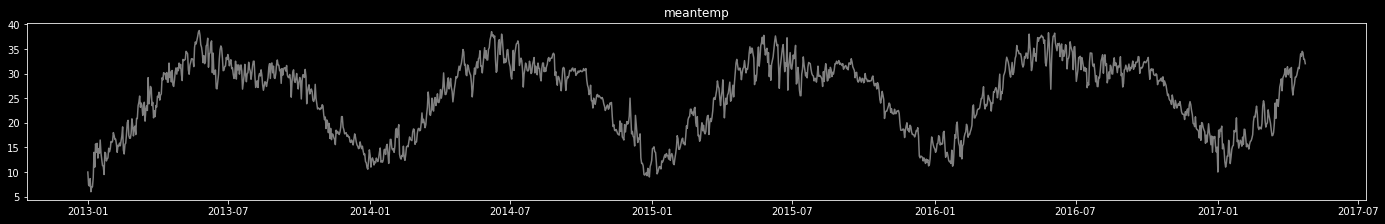

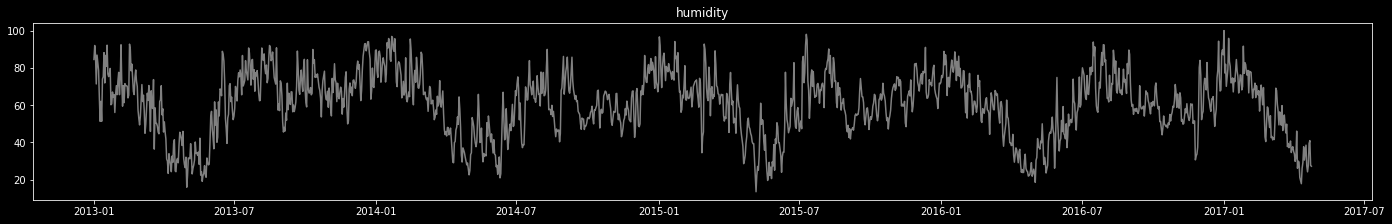

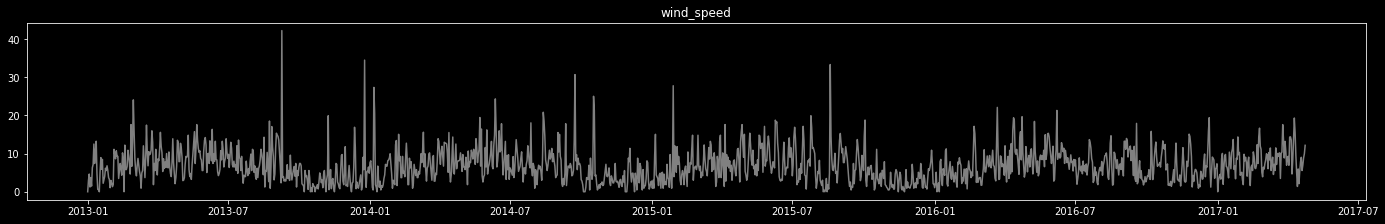

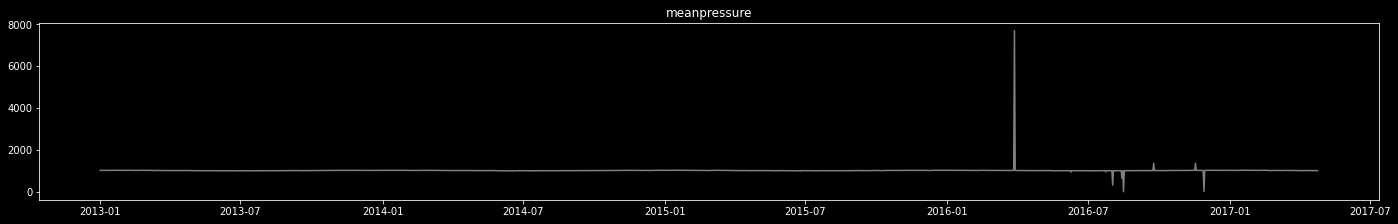

In [18]:
# ▶ Time Series 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

# ▶ for문 활용 시계열 센서 데이터 시각화
# ▶ 단일 변수로는 특별히 이상을 탐지하기 어려워 보임

for v, i in  enumerate(df.columns[1:5]) :
  plt.figure(figsize=(24,15))
  plt.subplot(4, 1, v+1)
  plt.plot(df['date'], df[i], linestyle='-', color='grey');
  plt.title(i)

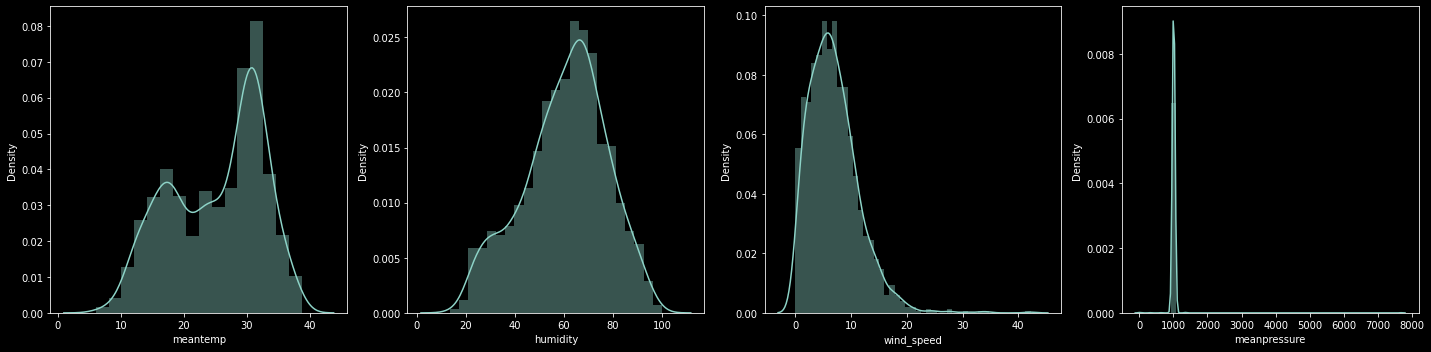

In [19]:
# ▶ checking numerical features distribution
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.figure(figsize = (20, 5))
plotnumber = 1

for column in df.columns[1:5]:
    if plotnumber <= 14:
        ax = plt.subplot(1, 4, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

## **🥈Session 2**  
**┗ 시계열 분해**  
---

목적 : 시계열 데이터를 상세하게 이해하기 위한 전통적인 방법

* Trend (추세) : 시간에 따라 변화하는 Trend
* Seasonality (계절성) : 반복되는 Trend
* Residual (잔차) : 그 밖에 불규칙한 패턴
  
  

※ 고전적인 분해의 한계점 (https://otexts.com/fppkr/classical-decomposition.html)
* 추세-주기 측정은 데이터에 나타나는 급격한 기울기 변화에 대해 불리 (과도하게 smoothing함)
* 계절성이 지속적으로 반복한다는 가정에 기반하기 때문에 계절성 변화에 대해 불리   
(ex. 전기수요패턴 - 이전에는 난방 때문에 겨울에 높게 나타났으나, 요즘은 여름 에어컨 때문에 높게 나타남. 이런 계절성 자체가 시간의 흐름에 따라 달라지지만 전통적 기법에서는 계절성이 일정하다고 가정하므로 확인이 어려움)
* **특이상황을 다루지 못함 **

### · Traditional Decomposition
---

In [20]:
# ▶ 데이터 확인
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [21]:
# ▶ 필요 Col select  >>  온도를 확인해보자
df_meantemp = df[['date', 'meantemp']]
df_meantemp.set_index('date', inplace = True)
df_meantemp.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


* 다른 문서에 보면 

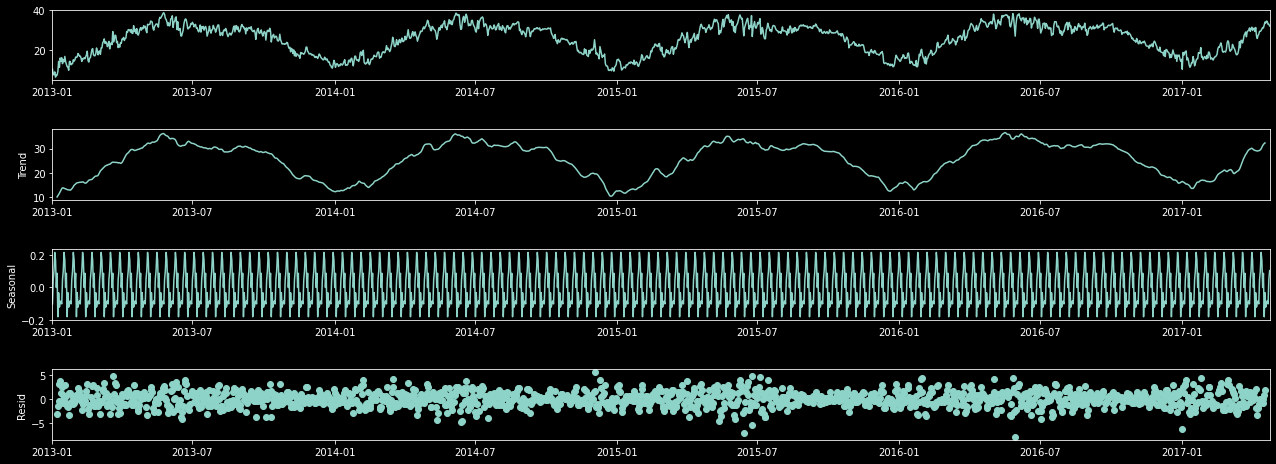

In [70]:
# ▶ 덧셈 분해 (additive decomposition) >> ★ 위에서 meantemp의 그래프를 보면, 추세에 따라 계절성이 증가하는 양상이 없기 때문에 곱셈 대신 덧셈 분해 사용
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_meantemp,model='addictive', period = 12) # ★ 강의에는 'freq' 파라미터로 되어있으나, 현재 'freq' 파라미터는 삭제된 상태. 'period' 를 대신 사용.
res.plot()
plt.gcf().set_size_inches(20, 7)
# plt.show()

In [71]:
# ▶ attribute 활용 실제 데이터 값 조회 가능
res.observed # 원본 값

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2017-04-20    34.500000
2017-04-21    34.250000
2017-04-22    32.900000
2017-04-23    32.875000
2017-04-24    32.000000
Length: 1575, dtype: float64

In [72]:
# ▶ Trend를 표현하기 위해 앞, 뒤에 일부 데이터가 사라짐 (★ 사라진 데이터 포인트에 대해서는 잔차를 알 수 없기 때문에 이상탐지가 불가능함 >> 치명적인 단점)
res.trend.head(10)

date
2013-01-01          NaN
2013-01-02          NaN
2013-01-03          NaN
2013-01-04          NaN
2013-01-05          NaN
2013-01-06          NaN
2013-01-07     9.976786
2013-01-08    10.446230
2013-01-09    10.987103
2013-01-10    11.516865
Name: trend, dtype: float64

★ 계절성 성분이 어떻게 계산되는지 직접 보기

In [73]:
tmp = res.observed - res.trend
tmp = tmp.to_frame().reset_index()
tmp.columns = ['date','observed_wo_trend']

tmp['year'] = tmp['date'].dt.year
tmp['month'] = tmp['date'].dt.month
tmp['day'] = tmp['date'].dt.day

tmp.head(10)

,date,observed_wo_trend,year,month,day
0,2013-01-01,NaN,2013,1,1
1,2013-01-02,NaN,2013,1,2
2,2013-01-03,NaN,2013,1,3
3,2013-01-04,NaN,2013,1,4
4,2013-01-05,NaN,2013,1,5
5,2013-01-06,NaN,2013,1,6
6,2013-01-07,-2.976786,2013,1,7
7,2013-01-08,-1.589087,2013,1,8
8,2013-01-09,3.012897,2013,1,9
9,2013-01-10,-0.516865,2013,1,10


In [75]:
# ▶ Seasonal 데이터 확인
res.seasonal.head(10)

date
2013-01-01   -0.102222
2013-01-02    0.047937
2013-01-03    0.103602
2013-01-04    0.215965
2013-01-05    0.167750
2013-01-06   -0.000775
2013-01-07    0.086911
2013-01-08   -0.181816
2013-01-09   -0.032941
2013-01-10   -0.122337
Name: seasonal, dtype: float64

In [76]:
tmp2 = res.seasonal.to_frame().reset_index()

tmp2['year'] = tmp2['date'].dt.year
tmp2['month'] = tmp2['date'].dt.month
tmp2['day'] = tmp2['date'].dt.day

tmp2

,date,seasonal,year,month,day
0,2013-01-01,-0.102222,2013,1,1
1,2013-01-02,0.047937,2013,1,2
2,2013-01-03,0.103602,2013,1,3
3,2013-01-04,0.215965,2013,1,4
4,2013-01-05,0.167750,2013,1,5
...,...,...,...,...,...
1570,2017-04-20,-0.098366,2017,4,20
1571,2017-04-21,-0.083706,2017,4,21
1572,2017-04-22,-0.102222,2017,4,22
1573,2017-04-23,0.047937,2017,4,23


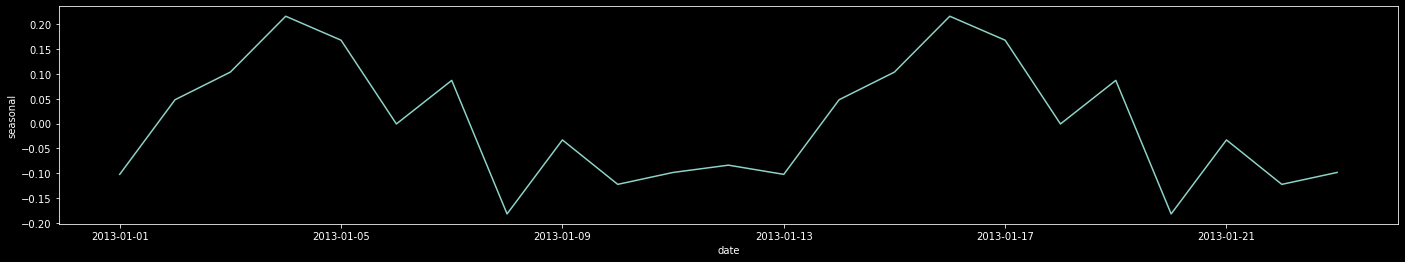

In [77]:
t = tmp2[tmp2.date<'2013-01-24'] # period로 설정했던 12일마다 반복 >> 보고자 하는 주기에 따라 변경해서 보면 될듯

plt.figure(figsize=(24,4))
sns.lineplot(x=t['date'],y=t['seasonal'])
plt.show()

In [ ]:
# ▶ 잔차 데이터 확인 >> 단순 MA를 사용하기 때문에 맨앞/맨뒤 값에 대한 잔차를 구할 수 없음
res.resid

date
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
              ..
2017-04-20   NaN
2017-04-21   NaN
2017-04-22   NaN
2017-04-23   NaN
2017-04-24   NaN
Name: resid, Length: 1575, dtype: float64

### · STL Decomposition
---

In [78]:
df_meantemp.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [79]:
df_meantemp.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-04-15', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24'],
              dtype='datetime64[ns]', name='date', length=1575, freq=None)

In [80]:
# ▶ STL을 위해서는 index에 freq가 선언되어 있어야함 
data = df_meantemp.resample('D').mean()

In [81]:
# ▶ freq = 'D' 확인 
data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-04-15', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24'],
              dtype='datetime64[ns]', name='date', length=1575, freq='D')

statsmodels의 STL 공식문서 : https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html

- period 직접 설정 가능
- trend smoother, seasonal smoother 조정 가능 : 전통적인 방식과 다르게 계절성의 변화를 허용

* seasonal 파라미터를 조절해가며 그래프를 그려본 결과, 
 seasonality에서 일정한 패턴이 발견되지는 않음 (반면에 trend는 일정한 패턴 존재)   
 (전통적 분해방법에서는 seasonality를 일정한 파형으로 해석하였음)

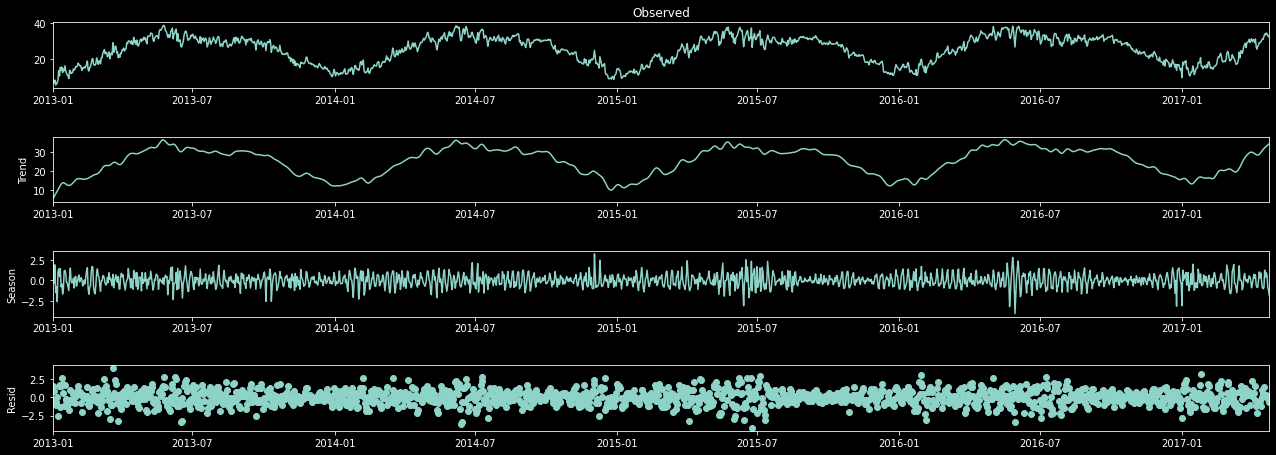

In [82]:
from statsmodels.tsa.seasonal import STL
# ▶ Odd num : seasonal = 13(연도별) / seasonal = 5(분기별) / seasonal = 7(주별) >> (seasonal : seasonal smoother의 길이를 결정하는 파라미터)
stl = STL(data, seasonal=5)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 7)

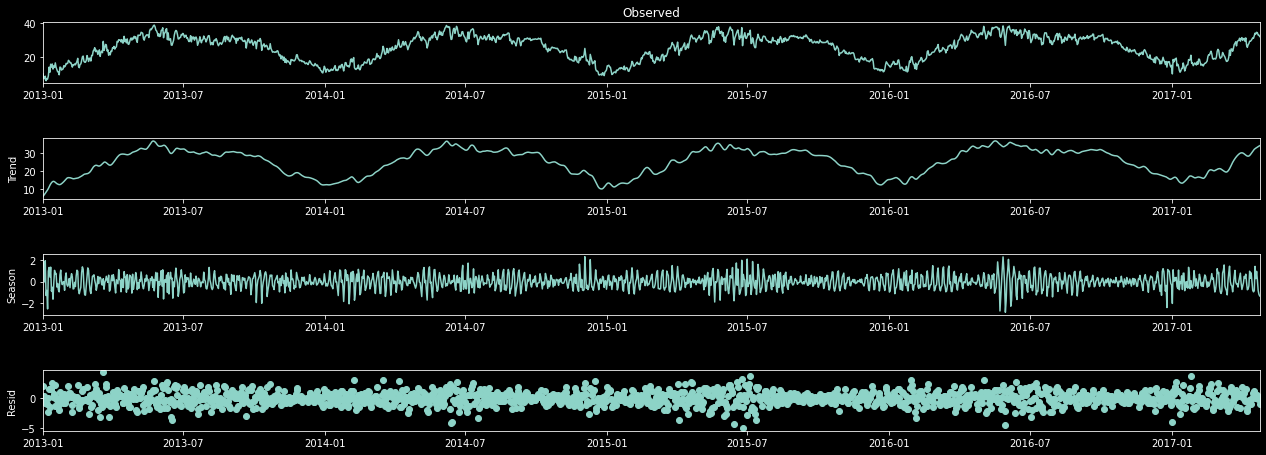

In [83]:
from statsmodels.tsa.seasonal import STL
# ▶ Odd num : seasonal = 13(연도별) / seasonal = 5(분기별) / seasonal = 7(주별)
stl = STL(data, seasonal=7)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 7)

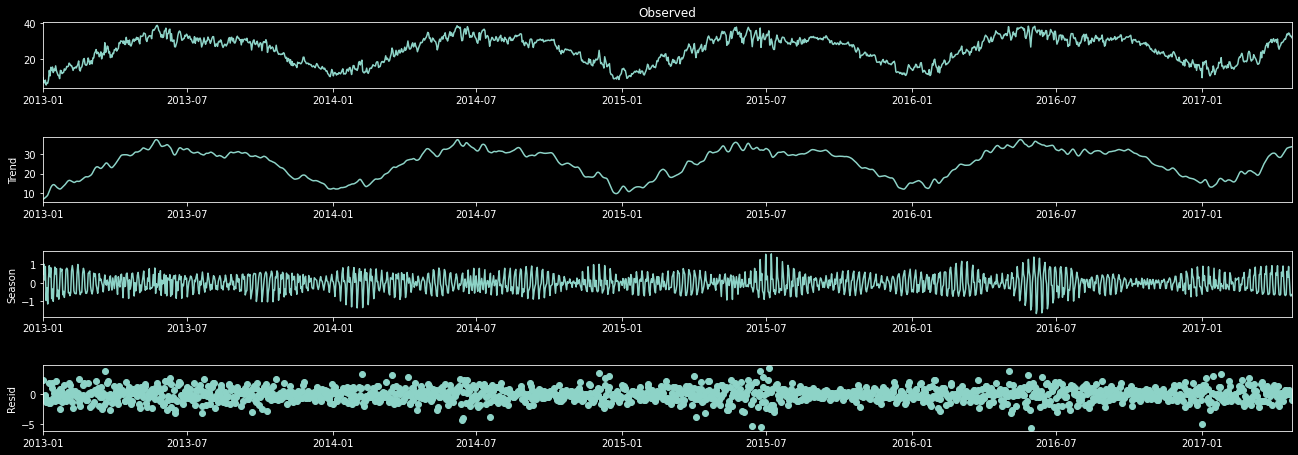

In [84]:
from statsmodels.tsa.seasonal import STL
# ▶ Odd num : seasonal = 13(연도별) / seasonal = 5(분기별) / seasonal = 7(주별)
stl = STL(data, seasonal=13)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(20, 7)

In [ ]:
# ▶ 앞, 뒤 값 채워져 있음 >> 전통적 분해방법과 비교해 장점
res.trend

date
2013-01-01     7.007179
2013-01-02     7.247100
2013-01-03     7.530121
2013-01-04     7.851253
2013-01-05     8.207553
                ...    
2017-04-20    33.210080
2017-04-21    33.335836
2017-04-22    33.447712
2017-04-23    33.542186
2017-04-24    33.616014
Freq: D, Name: trend, Length: 1575, dtype: float64

In [ ]:
# ▶ 앞, 뒤 값 채워져 있음
res.resid

date
2013-01-01    2.524990
2013-01-02   -0.866415
2013-01-03   -0.519578
2013-01-04   -0.070532
2013-01-05   -1.255954
                ...   
2017-04-20    0.398887
2017-04-21    0.764106
2017-04-22    0.096650
2017-04-23    0.045739
2017-04-24   -0.986313
Freq: D, Name: resid, Length: 1575, dtype: float64

## **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · Model Selection
---
* STL Anomaly Detection
```
# 시계열 분해 : 시계열을 몇 가지 성분을 나누어 이해하는 작업 (※ trend, sesonality, cycle)
🕝 시계열 분해 역사
(1) Classical Decomposition : 전통적인 시계열 분해, MA 구할 시 앞뒤 데이터 삭제, Robust하지 못함
(2) X11 : 미국 인구 조사국/캐나다 통계청 개발, 양 끝점 삭제 해결, 휴일 효과 등 캘린더 고려, 갑작스런 변화에 유연하게 대응
(3) SEATS : 스페인 은행 개발, 분기별, 월별 데이터에서만 작동
(4) STL(Sesonal and Trend decompostion usinf Loess)
# 다양한 상황에서 사용할 수 있는 강력한 시계열 분해 기법
# SEAT와 X11과 다르게 월별, 분기별 데이터 포함 어떤 종류의 계절성도 다룰 수 있음
# 계절적인 성분이 시간에 따라 변해도 Hyper parameter를 통해 반영할 수 있음
# Trend와 Sesonality를 제거하고 남는 Residual을 활용하여 시계열 데이터 이상 탐지
```
<img src = "https://drive.google.com/uc?id=1sxpqeudcgqZ8hreIEe8e8-l_Qay6QRDl">
* 장단점
```
  # [good] 분기별, 월별, 일별 분해 모두 가능 
  # [good] MA(Moving Avg) 방식이 아니기 때문에 데이터 유실 없음
  # [good] 돌발스런 이상치에 대해 추세, 주기에 영향을 미치지 않음 
  # [bad] 캘린더 데이터를 반영하지 못함, 일별 데이터로 변환하여 넣어줘야함
  # [bad] 덧셈 분해 기능만 제공
```

### · (1) STL modeling
---

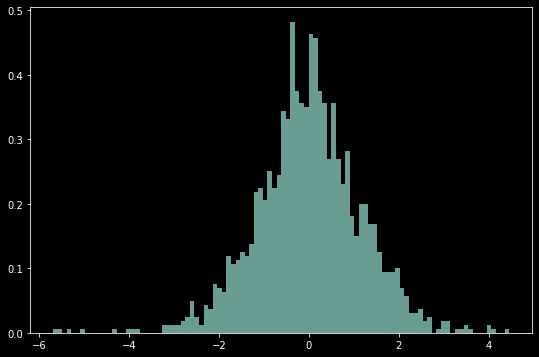

In [ ]:
# ▶ Residual(잔차)의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(res.resid, 100, density=True, alpha=0.75)

In [ ]:
# ▶ Ztest를 통한 정규성 검증(Nomality Test)
# ▶ Ztest : 정규분포를 가정하며, 추출된 표본이 동일 모집단(정규분포)에 속하는지 가설 검증하기 위해 사용 (※ p-value가 0.05 이상이면 정규성을 따름)
from statsmodels.stats.weightstats import ztest
r = res.resid.values
st, p = ztest(r)
print(st,p)  

0.007749403056367411 0.9938169328314919


In [ ]:
# ▶ 평균과 표준편차 출력
mu, std = res.resid.mean(), res.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(res.resid[(res.resid>mu+3*std)|(res.resid<mu-3*std)]))
# 이상치 갯수: 10

평균: 0.00022745498973910974 표준편차: 1.1648432781205584
이상치 갯수: 14


In [ ]:
res.resid[(res.resid>mu+3*std)|(res.resid<mu-3*std)].index

DatetimeIndex(['2013-03-20', '2014-06-13', '2014-06-14', '2014-07-18',
               '2014-12-03', '2015-04-04', '2015-06-14', '2015-06-24',
               '2015-06-25', '2015-07-05', '2016-05-02', '2016-05-30',
               '2017-01-01', '2017-01-25'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
# ▶ 이상 데이터 확인
data.loc[res.resid[(res.resid>mu+3*std)|(res.resid<mu-3*std)].index]

,meantemp
date,
2013-03-20,29.166667
2014-06-13,30.250000
2014-06-14,30.500000
2014-07-18,27.250000
2014-12-03,25.000000
2015-04-04,21.000000
2015-06-14,27.000000
2015-06-24,37.250000
2015-06-25,26.625000


In [ ]:
# ▶ UB, LB 설정 후 anomaly 부여 
stl_df = pd.DataFrame()
stl_df['value'] = res.resid
stl_df['raw'] = data

mean = res.resid.mean()
std = res.resid.std()

stl_df['anomaly_threshold_3r'] = mean + 3*std
stl_df['anomaly_threshold_3l'] = mean - 3*std
stl_df['anomaly']  = stl_df.apply(lambda x : 1 if (x['value'] > x['anomaly_threshold_3r']) or (x['value'] < x['anomaly_threshold_3l']) else 0, axis=1)

In [ ]:
stl_df

,value,raw,anomaly_threshold_3r,anomaly_threshold_3l,anomaly
date,,,,,
2013-01-01,2.524990,10.000000,3.494757,-3.494302,0
2013-01-02,-0.866415,7.400000,3.494757,-3.494302,0
2013-01-03,-0.519578,7.166667,3.494757,-3.494302,0
2013-01-04,-0.070532,8.666667,3.494757,-3.494302,0
2013-01-05,-1.255954,6.000000,3.494757,-3.494302,0
...,...,...,...,...,...
2017-04-20,0.398887,34.500000,3.494757,-3.494302,0
2017-04-21,0.764106,34.250000,3.494757,-3.494302,0
2017-04-22,0.096650,32.900000,3.494757,-3.494302,0


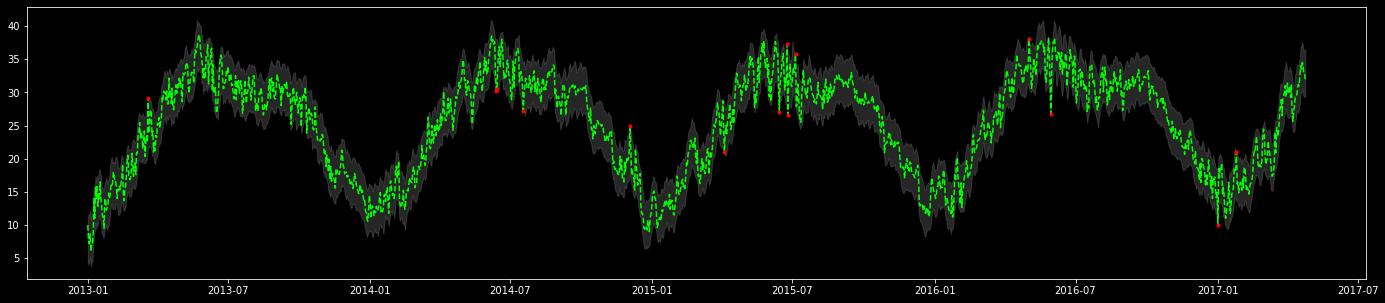

In [ ]:
# ▶ predict data
lower_bound = mu - 3*std
upper_bound = mu + 3*std

plt.figure(figsize=(24,5))
plt.plot(stl_df.index, stl_df['raw'], linestyle='--', color='lime');
plt.plot(stl_df[stl_df['anomaly']==1].index, stl_df[stl_df['anomaly']==1]['raw'], 'o', color='red', markersize=3);


# 이 코드는 시각적인 장치로, 꼭 필요한 내용은 아님
seasonal, trend, resid = res.seasonal, res.trend, res.resid
cleaned_data = seasonal + trend

plt.fill_between(data.index, cleaned_data - lower_bound, cleaned_data + lower_bound, color = 'gray', alpha = 0.3);

### · (2) S-H-ESD modeling
---

In [ ]:
# ▶ package 설치
!pip install pyculiarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.0/156.0 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyculiarity: filename=pyculiarity-0.0.7-py32-none-any.whl size=24796 sha256=e387a4193e21aea74750b018285a3c5631a84660bb988aabf3d2891e9a6bf5cf
  Stored in directory: /root/.cache/pip/wheels/00/28/c0/a863177364415b7a8afc7e33ede62c4ff9288fdf43b9afd098
Successfully built pyculiarity


In [ ]:
data.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [ ]:
# ▶ date를 숫자형태(int64)로 변환
import numpy as np
df_shesd = data.reset_index()
df_shesd.columns = ['date', 'meantemp']
df_shesd['date'] = np.int64(df_shesd['date'])
df_shesd.head()

,date,meantemp
0,1356998400000000000,10.000000
1,1357084800000000000,7.400000
2,1357171200000000000,7.166667
3,1357257600000000000,8.666667
4,1357344000000000000,6.000000


In [ ]:
# ▶ max_anoms: Maximum number of anomalies that S-H-ESD will detect as a percentage of the
# ▶ 참조 : https://github.com/zrnsm/pyculiarity/blob/master/pyculiarity/detect_ts.py
from pyculiarity import detect_ts
from pyculiarity.date_utils import date_format

results = detect_ts(df_shesd, max_anoms=0.40, direction='both') # 위아래로 최대 40% 이상치 잡겠다

In [ ]:
results

{'anoms': Empty DataFrame
 Columns: [timestamp, anoms]
 Index: [], 'plot': None}

* 탐지를 한 건도 못함..

In [ ]:
# ▶ """ Plotting """
# ▶ reformat the index and columns
timeS_DF = df_shesd.set_index('timestamp')

anomsDF = results['anoms']
anomsDF.drop(['timestamp'], axis = 1, inplace = True)
anomsDF['is_anom'] = True
# anomsDF.columns = ['anom_value','is_anom']

merged_DF = pd.merge(left = timeS_DF, right= anomsDF, left_index=True, right_index=True, how = 'left')
# merged_DF.drop('anom_value',axis = 1,inplace=True)

print('>>> the number of anomaly: ', len(results['anoms']))
print(results['anoms'].head())

>>> the number of anomaly:  0
Empty DataFrame
Columns: [anoms, is_anom]
Index: []


* S-H_ESD의 특징: 급격하게 변하는 데이터에 대해서는 잘 탐지하지만, 주기적인 패턴을 가진 데이터에 대해서는 탐지를 잘 하지 못함
> * ★ 추가로 보면 S-H-ESD의 경우 아래와 같은 데이터에 대해 성능이 매우 떨어짐   
    https://h3imdallr.github.io/2017-06-20/anomaly_detection/
  * 우리 실습 데이터는 빈도가 높고 계절성 파악이 어렵기 때문에 성능이 제대로 안 나왔을 수 있음


> ★ 데이터의 특징을 확인하고, 이에 적합한 방법을 채택하는 것이 중요